In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option("display.max_columns", 50)

In [11]:
d1 = pd.read_csv("dataset1.csv")

d1["start_time"] = pd.to_datetime(d1.get("start_time"), errors="coerce", dayfirst=True)
d1["month"] = d1["start_time"].dt.month

print("Loaded rows:", len(d1))
display(d1.head(3))


Loaded rows: 907


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,2017-12-30 18:37:00,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,12,30/12/2017 16:45,1.870833,0
1,2017-12-30 19:51:00,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,12,30/12/2017 16:45,3.100833,0
2,2017-12-30 19:51:00,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,12,30/12/2017 16:45,3.107500,0


In [12]:
def make_season_from_month(m):
    if pd.isna(m):
        return np.nan
    if m in [6, 7, 8]:
        return "winter"
    if m in [9, 10, 11]:
        return "spring"
    return np.nan  

d1["season_bat"] = d1["month"].apply(make_season_from_month)

season_counts = d1["season_bat"].value_counts(dropna=False)
print("Season counts (initial):", season_counts.to_dict())

if season_counts.get("winter", 0) < 5 or season_counts.get("spring", 0) < 5:
    
    def half_year(m):
        if pd.isna(m): 
            return np.nan
        return "winter" if m in [1,2,3,4,5,6] else "spring"
    d1["season_bat"] = d1["month"].apply(half_year)
    season_counts = d1["season_bat"].value_counts(dropna=False)
    print("⚠ Fallback applied. New counts:", season_counts.to_dict())

Season counts (initial): {nan: 907}
⚠ Fallback applied. New counts: {'winter': 881, 'spring': 26}


In [13]:
hes_col = "bat_landing_to_food"
if hes_col not in d1.columns:
    raise KeyError(f"Expected hesitation column '{hes_col}' not found in dataset1.csv")

bat_df = d1[["start_time", hes_col, "season_bat"]].copy()
bat_df[hes_col] = pd.to_numeric(bat_df[hes_col], errors="coerce")
bat_df = bat_df.dropna(subset=[hes_col, "season_bat"]).reset_index(drop=True)

print("Rows available for analysis:", len(bat_df))
print("\nCounts by season:")
print(bat_df["season_bat"].value_counts())

print("\nDescriptive stats by season:")
display(bat_df.groupby("season_bat")[hes_col].describe())

Rows available for analysis: 907

Counts by season:
season_bat
winter    881
spring     26
Name: count, dtype: int64

Descriptive stats by season:


,count,mean,std,min,25%,50%,75%,max
season_bat,,,,,,,,
spring,26.0,8.233616,7.892787,0.074016,2.0,5.0,14.5,26.0
winter,881.0,11.815821,28.011683,0.010238,1.0,4.0,11.0,443.0


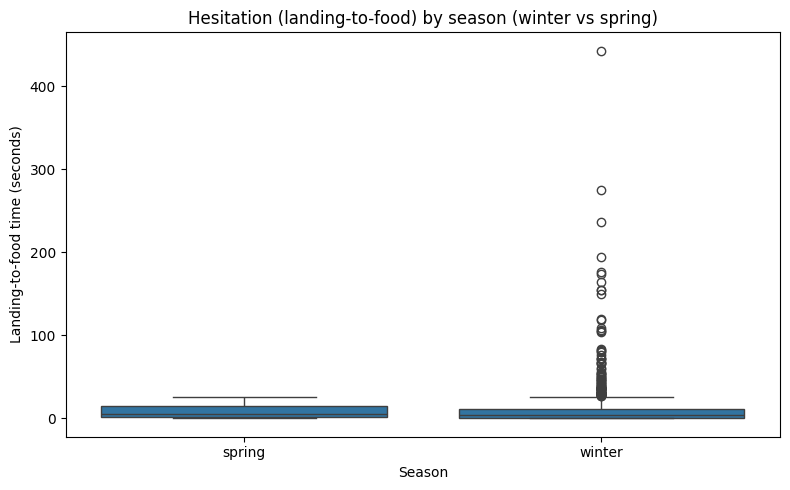

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data=bat_df, x="season_bat", y=hes_col)
plt.title("Hesitation (landing-to-food) by season (winter vs spring)")
plt.xlabel("Season")
plt.ylabel("Landing-to-food time (seconds)")
plt.tight_layout()
plt.savefig("B_boxplot_hesitation_by_season.png", dpi=150)
plt.show()

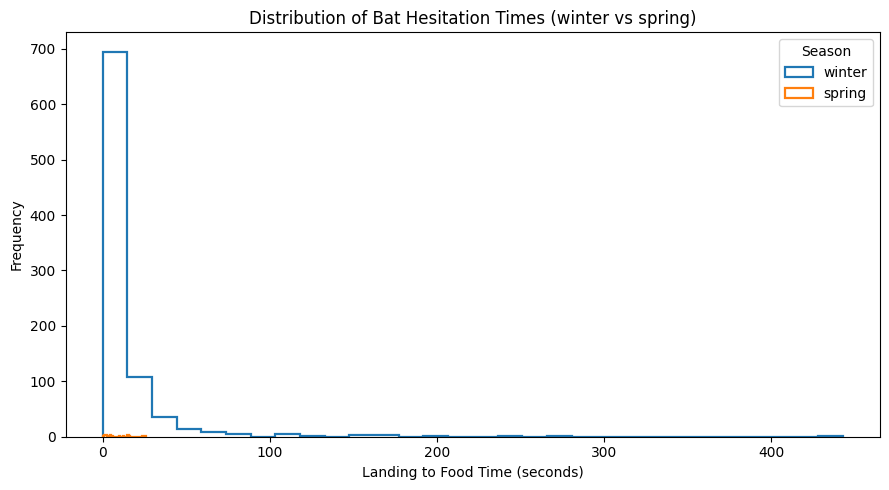

In [15]:
plt.figure(figsize=(9,5))
for s in ["winter", "spring"]:
    vals = bat_df.loc[bat_df["season_bat"]==s, hes_col].dropna()
    if len(vals):
        plt.hist(vals, bins=30, histtype="step", linewidth=1.6, label=s)
plt.title("Distribution of Bat Hesitation Times (winter vs spring)")
plt.xlabel("Landing to Food Time (seconds)")
plt.ylabel("Frequency")
plt.legend(title="Season")
plt.tight_layout()
plt.savefig("B_hist_hesitation_distribution.png", dpi=150)
plt.show()

In [16]:
if bat_df.empty:
    print("No rows available for regression. Fix earlier steps.")
else:
    model_df = bat_df.copy()
    model_df["season_dummy"] = model_df["season_bat"].map({"winter":0, "spring":1})
    model_df = model_df.dropna(subset=["bat_landing_to_food","season_dummy"])
    print("Rows used in regression:", len(model_df))

    if len(model_df) < 10:
        print("⚠️ Very few rows; regression will still run but interpret cautiously.")

    y = model_df["bat_landing_to_food"]
    X = sm.add_constant(model_df[["season_dummy"]])

    model = sm.OLS(y, X).fit()
    print(model.summary())

Rows used in regression: 907
                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.4238
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):              0.515
Time:                         04:39:14   Log-Likelihood:                -4297.0
No. Observations:                  907   AIC:                             8598.
Df Residuals:                      905   BIC:                             8608.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const    

In [17]:
bat_df["season_dummy"] = bat_df["season_bat"].map({"winter": 0, "spring": 1}).astype("float")

y = bat_df[hes_col]
X = sm.add_constant(bat_df[["season_dummy"]])

print(f"Rows used in regression: {len(X)}")
model = sm.OLS(y, X).fit()
print(model.summary())

Rows used in regression: 907
                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.4238
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):              0.515
Time:                         04:39:14   Log-Likelihood:                -4297.0
No. Observations:                  907   AIC:                             8598.
Df Residuals:                      905   BIC:                             8608.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const    

In [18]:
bat_df.to_csv("B_bat_seasonal_analysis_table.csv", index=False)
print("Saved: B_bat_seasonal_analysis_table.csv")

Saved: B_bat_seasonal_analysis_table.csv
